In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


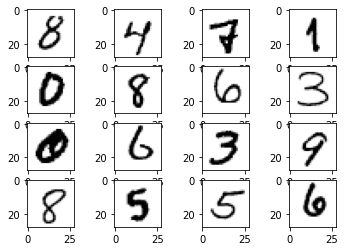

In [ ]:
# Load MNIST Data

transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x:x.view(28*28)),
        ])

batch_size = 128
train_loader = torch.utils.data.DataLoader(
        (datasets.MNIST('data', train=True, transform=transform_train,download=True)),
         batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        (datasets.MNIST('data', train=False, transform=transform_train,download=True)),
         batch_size=batch_size, shuffle=True)

print(train_loader.dataset.data.shape)
print(train_loader.dataset.targets.shape)
print(test_loader.dataset.data.shape)
print(test_loader.dataset.targets.shape)

x,y = next(iter(train_loader))

# Display 16 images chosen at random
for index,img in enumerate(x[:16]):
    plt.subplot(4,4,index+1)
    plt.imshow(img.reshape(28,28),cmap="Greys")

## Custom AutoDiff

In [ ]:
%load_ext autoreload
%autoreload 2
# The autoreload helps in automatically reloading the module as soon as 
# it changes on the disk. 

import CustomAutoDiff as cad  

In [ ]:
activation_map = {
    "sigmoid": [cad.Sigmoid,F.sigmoid],
    "relu": [cad.ReLU,F.relu],
    "tanh": [cad.Tanh,F.tanh]
}

## Custom NN


In [ ]:
class CustomNN:
    def __init__(self,conf):
        self.weights = [cad.Variable(weight) for weight in conf.weights]
        self.biases = [cad.Variable(bias) for bias in conf.biases]
        self.activations = [activation_map[activation][0] for activation in conf.activations]
        self.learning_rate = conf.learning_rate
        self.momentum = conf.momentum
        self.v = {0:[], 1: [], 2: [], 3: [], 4: [], 5: []}
        
    def forward(self,batch):
        # Describe what the following function does. 
        """
        This method implements the forward propagation step in our network where we multiply the batch input(temp) with 
        weights and add bias to it, the output for this contain the output of all the neurons in the layer.
        We take the last column of weights as the output which would be the logits, after which we apply softmax to it, 
        which basically gives us the probability distribution for our logit layer. 
        """
        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        logits = temp@self.weights[-1]+self.biases[-1]
        softmax = logits.exp()/logits.exp().sum(axis=1)
        return logits.value
    
    def loss_and_gradients(self,batch,targets):
        for param in self.weights+self.biases:
            param.reset()
        
        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        
        logits = temp@self.weights[-1]+self.biases[-1]
        
        # Why do we do this? 
        """
        We try to find the maximum value which would be our predicted class and subtract the value with everything.
        This results in negative value for everything other the predicted class and the predicted class would be 0.
        Now when we apply softmax rather than just argmax, e**x for predicted class would yield 1 and others would 
        would very low number. This would result in high probability for the predicted class and lower probabilities for the other classes.
        """
        logits = logits + (-logits.value.max(axis=1,keepdims=True))
        softmax = logits.exp()/logits.exp().sum(axis=1)
        
        # Why did we add 10**-6 to softmax?
        """
        Here we are doing log operation, since log 0 is undefined we tried to add very small number to softmax in this case if it has any zero probability.
        """
        # Why did we multiply with "-targets"?
        """
        when we apply log to softmax probabilities, we will have a negative value, so we multiply with -target to get a positive loss
        """
        loss = ((softmax+10**-6).log() * cad.Variable(-targets)).sum(axis=0).sum(axis=1)/batch.shape[0]
        
        loss.gradient = 1
        loss.backward()
        return {
            "loss" :loss.value,
            "grads":[param.gradient for param in (self.weights+self.biases)]
        }
    


    def apply_gradients(self):
        for i, param in enumerate(self.weights+self.biases):
            if len(self.v[i]) == 0:
                self.v[i] = np.zeros_like(param.gradient)
            self.v[i] = self.momentum * self.v[i] +  param.gradient
            param.value -= self.v[i] * self.learning_rate 
            param.reset()

## Torch NN


In [ ]:
class TorchNN(torch.nn.Module):
    def __init__(self,conf):
        super(TorchNN,self).__init__()
        
        self.weights = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(weight)) for weight in conf.weights])
        self.biases = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(bias)) for bias in conf.biases])
        
        self.activations = [activation_map[activation][1] for activation in conf.activations]
        self.learning_rate = conf.learning_rate
        
        self.optimizer = torch.optim.SGD(self.parameters(),lr=conf.learning_rate, momentum=conf.momentum)
        
    def forward(self,batch):
        temp = torch.FloatTensor(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        logits = temp@self.weights[-1]+self.biases[-1]
        
        softmax = torch.exp(logits)/torch.exp(logits).sum(dim=1,keepdims=True)
        
        return logits
    
    def loss_and_gradients(self,batch,targets):
        for param in self.weights:
            if param._grad !=None:param._grad.zero_()
        for param in self.biases:
            if param._grad !=None:param._grad.zero_()
        
        temp = torch.FloatTensor(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        
        logits = temp@self.weights[-1]+self.biases[-1]
        
        logits = logits + (-logits.max(dim=1,keepdims=True)[0])
        softmax = logits.exp()/logits.exp().sum(dim=1,keepdims=True)
        
        loss = (torch.log(softmax+10**-6) * (-targets)).sum(axis=1).mean(axis=0)
        
        loss.backward()
        return {
            "loss" :loss,
            "grads":[param._grad for param in (self.weights)]+
            [param._grad for param in (self.biases)]
        }
    
    def apply_gradients(self):
        self.optimizer.step()
        self.optimizer.zero_grad()

## Comparing Custom NN and Torch NN



Preparing weights

In [ ]:
class Conf:
    def __init__(self,hidden_layers,activations,learning_rate, momentum):
        number_units = [784] + hidden_layers + [10]
        weights = []
        biases = []
        for prev,curr in zip(number_units,number_units[1:]):
            np.random.seed(1)
            weights.append(np.random.randn(prev,curr).astype(dtype=np.float64)/100)
            biases.append(np.zeros([1,curr],dtype=np.float64))
        self.weights = weights
        self.biases = biases
        self.activations = activations
        self.learning_rate = learning_rate
        self.momentum = momentum

conf = Conf(hidden_layers=[100,50],
           activations=["tanh","tanh"],
           learning_rate=0.1, momentum=0.9)
"""
Let's create two instances of the above Neural Network configuration - 
one built on custom AutoDiff framework and the other built on Torch Library. 
"""

customNN = CustomNN(conf)
tensorNN = TorchNN(conf)

We will first make sure that our code is correct by comparing the results against that of PyTorch's. 

<b>Comparing forward pass</b>

In [ ]:
dat,_ = next(iter(train_loader))
t1 = customNN.forward(np.array(dat))
t2 = tensorNN.forward(dat).detach().numpy()
print((np.abs(t2-t1)).mean())

1.405986465815729e-10


c:\users\hp\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


<b>Comparing Gradients</b>

In [ ]:
dat,lab = next(iter(train_loader))
lab = F.one_hot(lab,10)
t1 = customNN.loss_and_gradients(dat.numpy(),lab.numpy())
t2 = tensorNN.loss_and_gradients(dat,lab)
print(t1["loss"],t2["loss"])
for i,j in zip(t1["grads"],t2["grads"]):
    print((np.abs(j-i)).mean())

[[2.3024434]] tensor(2.3024, grad_fn=<MeanBackward1>)
tensor(2.6389e-12, dtype=torch.float64)
tensor(1.5719e-11, dtype=torch.float64)
tensor(6.2414e-11, dtype=torch.float64)
tensor(9.4772e-12, dtype=torch.float64)
tensor(1.1637e-10, dtype=torch.float64)
tensor(3.2589e-09, dtype=torch.float64)


<b>Comparing Test Accuracies for 10 steps of training </b>

In [ ]:
for epoch in range(10):
    for train_dat,train_lab in train_loader:
        train_lab = F.one_hot(train_lab,10)
        
        # TensorNN update
        _ = tensorNN.loss_and_gradients(train_dat,train_lab)
        tensorNN.apply_gradients()
        
        # CustomNN update
        loss_and_grads1 = customNN.loss_and_gradients(train_dat.numpy(),train_lab.numpy())
        customNN.apply_gradients()
    
    tensorNN_correct = 0
    customNN_correct = 0
    for test_dat,test_lab in test_loader:

        # TensorNN Accuracy
        preds = tensorNN.forward(test_dat).detach().numpy()
        tensorNN_correct += (np.argmax(preds,axis=1)==test_lab.numpy()).sum()

        # CustomNN Accuracy
        preds = customNN.forward(test_dat.numpy())
        customNN_correct += (np.argmax(preds,axis=1)==test_lab.numpy()).sum()

    total = test_loader.dataset.data.shape[0]
    print("Epoch {}: {} {}".format(epoch,tensorNN_correct/total,customNN_correct/total))

Epoch 0: 0.9365 0.9365
Epoch 1: 0.962 0.962
Epoch 2: 0.9684 0.9684
Epoch 3: 0.9706 0.9706
Epoch 4: 0.9724 0.9724
Epoch 5: 0.97 0.97
Epoch 6: 0.9742 0.9742
Epoch 7: 0.9733 0.9733
Epoch 8: 0.9747 0.9747
Epoch 9: 0.9771 0.9771
